In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from typing import List, Optional, Tuple, Union, Dict

import numpy as np
import pandas as pd

from simulator import MdUpdate, Order, OwnTrade, Sim, update_best_positions

In [101]:
class StoikovAvellanedaStrategy:
      def __init__(self, delay: float, gamma: float, sigma: float, max_pos: float, hold_time: Optional[float] = None) -> None:
        self.hold_time = hold_time
        self.delay = delay
        self.gamma = gamma
        self.sigma = sigma
        self.max_pos = max_pos

      def run(self, sim: Sim) -> \
            Tuple[List[OwnTrade], List[MdUpdate], List[Union[OwnTrade, MdUpdate]], List[Order]]:
        '''
            This function runs simulation

            Args:
                sim(Sim): simulator
            Returns:
                trades_list(List[OwnTrade]): list of our executed trades
                md_list(List[MdUpdate]): list of market data received by strategy
                updates_list( List[ Union[OwnTrade, MdUpdate] ] ): list of all updates
                received by strategy(market data and information about executed trades)
                all_orders(List[Orted]): list of all placed orders
        '''

        # market data list
        md_list: List[MdUpdate] = []
        # executed trades list
        trades_list: List[OwnTrade] = []
        # all updates list
        updates_list = []
        # current best positions
        best_bid = -np.inf
        best_ask = np.inf

        # last order timestamp
        prev_time = -np.inf
        # orders that have not been executed/canceled yet
        ongoing_orders: Dict[int, Order] = {}
        all_orders = []

        q = 0.

        while True:
            # get update from simulator
            receive_ts, updates = sim.tick()
            if updates is None:
                break
            # save updates
            updates_list += updates
            for update in updates:
                # update best position
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    md_list.append(update)
                elif isinstance(update, OwnTrade):
                    trades_list.append(update)
                    if update.side == 'BID':
                        q += 0.001
                    else:
                        q -= 0.001

                    # delete executed trades from the dict
                    if update.order_id in ongoing_orders.keys():
                        ongoing_orders.pop(update.order_id)
                else:
                    assert False, 'invalid type of update!'

            if receive_ts - prev_time >= self.delay:
                prev_time = receive_ts

                s = (best_bid + best_ask) / 2
                w = 0.5 * self.gamma**2 * self.sigma**2 * (self.max_pos + 1)**2
                coef = self.gamma**2 * self.sigma**2 / (2 * w - self.gamma**2 * q**2 * self.sigma**2)
                r_ask = s + np.log(1 + (1 - 2 * q) * coef) / self.gamma
                r_bid = s + np.log(1 + (-1 - 2 * q) * coef) / self.gamma

                # place order
                if q < self.max_pos:
                  bid_order = sim.place_order(receive_ts, 0.001, 'BID', r_bid)
                ask_order = sim.place_order(receive_ts, 0.001, 'ASK', r_ask)
                ongoing_orders[bid_order.order_id] = bid_order
                ongoing_orders[ask_order.order_id] = ask_order

                all_orders += [bid_order, ask_order]

            to_cancel = []
            for ID, order in ongoing_orders.items():
                if order.place_ts < receive_ts - self.hold_time:
                    sim.cancel_order(receive_ts, ID)
                    to_cancel.append(ID)
            for ID in to_cancel:
                ongoing_orders.pop(ID)

        return trades_list, md_list, updates_list, all_orders

In [102]:
from get_info import get_pnl
from load_data import load_md_from_file
from matplotlib import pyplot as plt

In [103]:
PATH_TO_FILE = '/content/drive/MyDrive/CMF_strategy/md/btcusdt_Binance_LinearPerpetual/'
NROWS = 1000000

In [104]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [105]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [106]:
delay = pd.Timedelta(0.01, 's').delta
gamma = 1
sigma = 0.1
max_pos = 0.01
hold_time = pd.Timedelta(0.1, 's').delta

strategy = StoikovAvellanedaStrategy(delay, gamma, sigma, max_pos, hold_time)

In [107]:
%time trades_list, md_list, updates_list, all_orders = strategy.run(sim)

CPU times: user 2min 24s, sys: 2.37 s, total: 2min 26s
Wall time: 2min 27s


In [108]:
%time df = get_pnl(updates_list)

CPU times: user 1min 51s, sys: 402 ms, total: 1min 51s
Wall time: 1min 53s


In [109]:
df

,receive_ts,exchange_ts,total,BTC,USD,mid_price
0,1655942402250125991,1655942402249000000,0.000000,0.000,0.000000,19977.45
1,1655942402624789714,1655942402623000000,0.000000,0.000,0.000000,19977.45
2,1655942402657844605,1655942402655000000,0.000000,0.000,0.000000,19977.45
3,1655942403346968722,1655942403346000000,0.000000,0.000,0.000000,19977.45
4,1655942404080791047,1655942404080000000,0.000000,0.000,0.000000,19977.45
...,...,...,...,...,...,...
2082889,1655976251949195377,1655976251948000000,-360.295459,-0.185,3451.823791,20606.05
2082890,1655976251980811262,1655976251980000000,-360.295459,-0.185,3451.823791,20606.05
2082891,1655976252013040555,1655976252012000000,-359.980959,-0.185,3451.823791,20604.35
2082892,1655976252022000000,1655976252012000000,-359.984083,-0.181,3369.403267,20604.35


In [110]:
dt = pd.to_datetime(df.receive_ts)

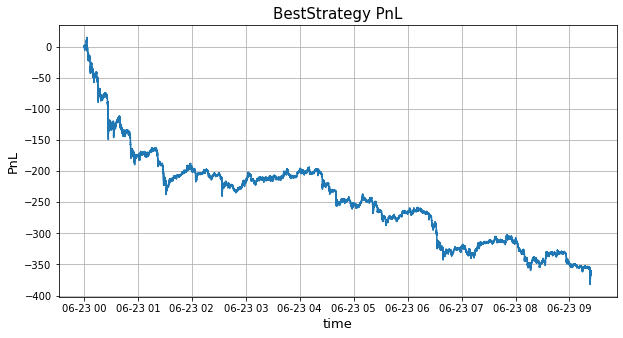

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()